## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate=False):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
                
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
# 設定超參數
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [32, 128, 256]
PRE_ACTIVATE = [True, False]
MOMENTUM = 0.95

In [7]:
results = {}

import itertools
for preact, bz in itertools.product(PRE_ACTIVATE, BATCH_SIZE):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Pre Activation: %s, Batch_size: %i" % (preact, bz))
    model = build_mlp(input_shape=x_train.shape[1:], pre_activate=preact)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bz, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "Pre Activation: %s, Batch_size: %s" % (preact, str(bz))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Pre Activation: True, Batch_size: 32
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)      

Epoch 1/50



1563/1563 [==============================] - 21s 12ms/step - loss: 1.6555 - accuracy: 0.4081 - val_loss: 2.1941 - val_accuracy: 0.3012
Epoch 2/50
1563/1563 [==============================] - 18s 12ms/step - loss: 1.4490 - accuracy: 0.4839 - val_loss: 1.5672 - val_accuracy: 0.4328
Epoch 3/50
1563/1563 [==============================] - 18s 11ms/step - loss: 1.3566 - accuracy: 0.5155 - val_loss: 1.5912 - val_accuracy: 0.4364
Epoch 4/50
1563/1563 [==============================] - 18s 12ms/step - loss: 1.2781 - accuracy: 0.5430 - val_loss: 1.7672 - val_accuracy: 0.3924
Epoch 5/50
1563/1563 [==============================] - 18s 11ms/step - loss: 1.2131 - accuracy: 0.5714 - val_loss: 1.3787 - val_accuracy: 0.5141
Epoch 6/50
1563/1563 [==============================] - 18s 11ms/step - loss: 1.1482 - accuracy: 0.5941 - val_loss: 1.3477 - val_accuracy: 0.5193
Epoch 7/50
1563/1563 [==============================] - 18s 11ms/step - loss: 1.0984 - accuracy: 0.6097 - val_loss: 1.5865 - val_accura

Epoch 1/50
391/391 [==============================] - 5s 9ms/step - loss: 1.6113 - accuracy: 0.4254 - val_loss: 1.7078 - val_accuracy: 0.3863
Epoch 2/50
391/391 [==============================] - 3s 9ms/step - loss: 1.3778 - accuracy: 0.5089 - val_loss: 1.7490 - val_accuracy: 0.3596
Epoch 3/50
391/391 [==============================] - 3s 9ms/step - loss: 1.2646 - accuracy: 0.5507 - val_loss: 1.6555 - val_accuracy: 0.4164
Epoch 4/50
391/391 [==============================] - 3s 8ms/step - loss: 1.1749 - accuracy: 0.5808 - val_loss: 1.5640 - val_accuracy: 0.4431
Epoch 5/50
391/391 [==============================] - 3s 8ms/step - loss: 1.0908 - accuracy: 0.6137 - val_loss: 1.6669 - val_accuracy: 0.4352
Epoch 6/50
391/391 [==============================] - 3s 8ms/step - loss: 1.0207 - accuracy: 0.6379 - val_loss: 1.5353 - val_accuracy: 0.4612
Epoch 7/50
391/391 [==============================] - 3s 8ms/step - loss: 0.9544 - accuracy: 0.6631 - val_loss: 1.6239 - val_accuracy: 0.4513
Epoch 

Epoch 1/50
196/196 [==============================] - 3s 13ms/step - loss: 1.6225 - accuracy: 0.4243 - val_loss: 2.2798 - val_accuracy: 0.2723
Epoch 2/50
196/196 [==============================] - 2s 12ms/step - loss: 1.3727 - accuracy: 0.5119 - val_loss: 1.8559 - val_accuracy: 0.3486
Epoch 3/50
196/196 [==============================] - 2s 12ms/step - loss: 1.2513 - accuracy: 0.5551 - val_loss: 1.8765 - val_accuracy: 0.3576
Epoch 4/50
196/196 [==============================] - 2s 12ms/step - loss: 1.1577 - accuracy: 0.5888 - val_loss: 2.0315 - val_accuracy: 0.3218
Epoch 5/50
196/196 [==============================] - 2s 12ms/step - loss: 1.0735 - accuracy: 0.6211 - val_loss: 2.6218 - val_accuracy: 0.2865
Epoch 6/50
196/196 [==============================] - 2s 12ms/step - loss: 0.9919 - accuracy: 0.6456 - val_loss: 1.7763 - val_accuracy: 0.3990
Epoch 7/50
196/196 [==============================] - 2s 12ms/step - loss: 0.9257 - accuracy: 0.6730 - val_loss: 1.8966 - val_accuracy: 0.4021

Epoch 1/50
1563/1563 [==============================] - 12s 7ms/step - loss: 1.7561 - accuracy: 0.3758 - val_loss: 1.7890 - val_accuracy: 0.3589
Epoch 2/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.5915 - accuracy: 0.4308 - val_loss: 1.7368 - val_accuracy: 0.3804
Epoch 3/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.5068 - accuracy: 0.4618 - val_loss: 1.7004 - val_accuracy: 0.4018
Epoch 4/50
1563/1563 [==============================] - 10s 7ms/step - loss: 1.4501 - accuracy: 0.4852 - val_loss: 1.5341 - val_accuracy: 0.4653
Epoch 5/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3977 - accuracy: 0.5017 - val_loss: 1.5566 - val_accuracy: 0.4429
Epoch 6/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3625 - accuracy: 0.5156 - val_loss: 1.4910 - val_accuracy: 0.4674
Epoch 7/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3328 - accuracy: 0.5243 - val_loss: 1.5478 - val_ac

Epoch 1/50
391/391 [==============================] - 12s 22ms/step - loss: 1.6902 - accuracy: 0.4060 - val_loss: 1.8600 - val_accuracy: 0.3555
Epoch 2/50
391/391 [==============================] - 7s 19ms/step - loss: 1.4956 - accuracy: 0.4658 - val_loss: 1.9435 - val_accuracy: 0.3210
Epoch 3/50
391/391 [==============================] - 7s 18ms/step - loss: 1.4104 - accuracy: 0.4979 - val_loss: 1.9512 - val_accuracy: 0.3469
Epoch 4/50
391/391 [==============================] - 7s 19ms/step - loss: 1.3333 - accuracy: 0.5243 - val_loss: 1.5880 - val_accuracy: 0.4432
Epoch 5/50
391/391 [==============================] - 7s 18ms/step - loss: 1.2898 - accuracy: 0.5411 - val_loss: 1.6948 - val_accuracy: 0.4129
Epoch 6/50
391/391 [==============================] - 7s 18ms/step - loss: 1.2385 - accuracy: 0.5597 - val_loss: 1.4730 - val_accuracy: 0.4843
Epoch 7/50
391/391 [==============================] - 7s 18ms/step - loss: 1.1882 - accuracy: 0.5787 - val_loss: 1.5249 - val_accuracy: 0.464

Epoch 1/50
196/196 [==============================] - 6s 23ms/step - loss: 1.6820 - accuracy: 0.4035 - val_loss: 1.8112 - val_accuracy: 0.3755
Epoch 2/50
196/196 [==============================] - 4s 20ms/step - loss: 1.4646 - accuracy: 0.4804 - val_loss: 1.7667 - val_accuracy: 0.3900
Epoch 3/50
196/196 [==============================] - 4s 19ms/step - loss: 1.3753 - accuracy: 0.5118 - val_loss: 1.6226 - val_accuracy: 0.4286
Epoch 4/50
196/196 [==============================] - 4s 19ms/step - loss: 1.3132 - accuracy: 0.5339 - val_loss: 1.7176 - val_accuracy: 0.3961
Epoch 5/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2537 - accuracy: 0.5576 - val_loss: 2.1607 - val_accuracy: 0.3222
Epoch 6/50
196/196 [==============================] - 4s 19ms/step - loss: 1.2020 - accuracy: 0.5726 - val_loss: 1.7269 - val_accuracy: 0.4160
Epoch 7/50
196/196 [==============================] - 4s 19ms/step - loss: 1.1655 - accuracy: 0.5870 - val_loss: 1.8413 - val_accuracy: 0.3850

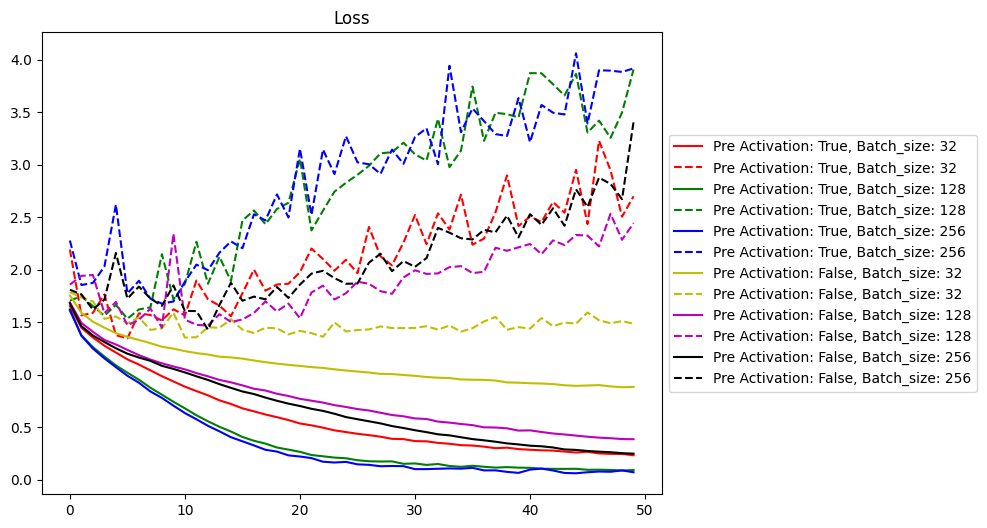

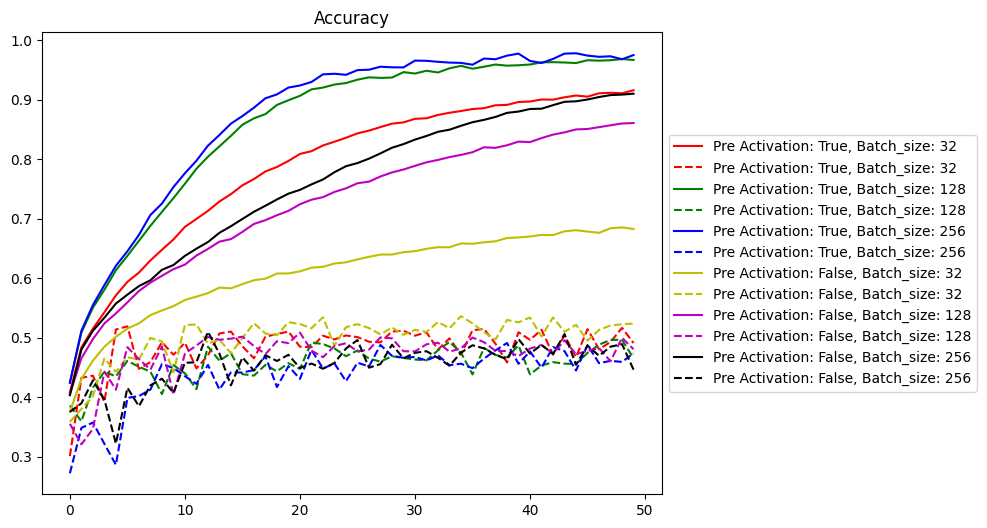

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()